<a href="https://colab.research.google.com/github/RumethR/Gait_Analysis_wSmartwatch/blob/master/WISDM_w_Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

accelerometer_data_file_path = '/content/drive/MyDrive/Implementation/watch/accel'
acc_files = os.listdir(accelerometer_data_file_path)
print(acc_files[0]) #Note that this won't print the first file in the directory, but the list has all files

gyroscope_data_file_path = '/content/drive/MyDrive/Implementation/watch/gyro'
gyro_files = os.listdir(gyroscope_data_file_path) #Note that the list contains 52 files because the first one is a .DS_Store file
print(gyro_files[0])

data_1626_accel_watch.txt
data_1629_gyro_watch.txt


In [5]:
import glob
acc_file_paths = glob.glob('/content/drive/MyDrive/Implementation/watch/accel/*')
gyro_file_paths = glob.glob('/content/drive/MyDrive/Implementation/watch/gyro/*')

In [6]:
for acc,gy in zip(acc_file_paths, gyro_file_paths):
  print(acc,gy)

/content/drive/MyDrive/Implementation/watch/accel/data_1626_accel_watch.txt /content/drive/MyDrive/Implementation/watch/gyro/data_1629_gyro_watch.txt
/content/drive/MyDrive/Implementation/watch/accel/data_1631_accel_watch.txt /content/drive/MyDrive/Implementation/watch/gyro/data_1626_gyro_watch.txt
/content/drive/MyDrive/Implementation/watch/accel/data_1605_accel_watch.txt /content/drive/MyDrive/Implementation/watch/gyro/data_1633_gyro_watch.txt
/content/drive/MyDrive/Implementation/watch/accel/data_1608_accel_watch.txt /content/drive/MyDrive/Implementation/watch/gyro/data_1644_gyro_watch.txt
/content/drive/MyDrive/Implementation/watch/accel/data_1650_accel_watch.txt /content/drive/MyDrive/Implementation/watch/gyro/data_1625_gyro_watch.txt
/content/drive/MyDrive/Implementation/watch/accel/data_1600_accel_watch.txt /content/drive/MyDrive/Implementation/watch/gyro/data_1649_gyro_watch.txt
/content/drive/MyDrive/Implementation/watch/accel/data_1623_accel_watch.txt /content/drive/MyDrive/I

In [7]:
# Map respective gyro file for the subject for the selected acc file
wisdm_dataset = {}

for acc_file in acc_files:
  #get the subject_id
  acc_file_name = acc_file.split("_") #The second index will contain the subject_id
  for gyro_file in gyro_files:
    gyro_file_name = gyro_file.split("_")
    if acc_file_name[1] == gyro_file_name[1]:
      wisdm_dataset[acc_file] = gyro_file
      gyro_files.remove(gyro_file)

print(wisdm_dataset)

{'data_1626_accel_watch.txt': 'data_1626_gyro_watch.txt', 'data_1631_accel_watch.txt': 'data_1631_gyro_watch.txt', 'data_1605_accel_watch.txt': 'data_1605_gyro_watch.txt', 'data_1608_accel_watch.txt': 'data_1608_gyro_watch.txt', 'data_1650_accel_watch.txt': 'data_1650_gyro_watch.txt', 'data_1600_accel_watch.txt': 'data_1600_gyro_watch.txt', 'data_1623_accel_watch.txt': 'data_1623_gyro_watch.txt', 'data_1612_accel_watch.txt': 'data_1612_gyro_watch.txt', 'data_1620_accel_watch.txt': 'data_1620_gyro_watch.txt', 'data_1637_accel_watch.txt': 'data_1637_gyro_watch.txt', 'data_1618_accel_watch.txt': 'data_1618_gyro_watch.txt', 'data_1633_accel_watch.txt': 'data_1633_gyro_watch.txt', 'data_1635_accel_watch.txt': 'data_1635_gyro_watch.txt', 'data_1611_accel_watch.txt': 'data_1611_gyro_watch.txt', 'data_1619_accel_watch.txt': 'data_1619_gyro_watch.txt', 'data_1601_accel_watch.txt': 'data_1601_gyro_watch.txt', 'data_1614_accel_watch.txt': 'data_1614_gyro_watch.txt', 'data_1616_accel_watch.txt': '

# Formatting and Segementing into 10-second instances

In [8]:
def format_and_segment_data(acc_data, gyro_data):
    def round_to_10_seconds(timestamp):
        return timestamp - (timestamp % 10**10)  # 10 seconds in nanoseconds

    def format_data(raw_data):
        formatted_data = []
        for entry in raw_data:
            split_entry = entry[:-1].split(',')
            split_entry[2] = int(split_entry[2])
            for index in range(3, len(split_entry)):
                split_entry[index] = float(split_entry[index])
            formatted_data.append(split_entry)
        return formatted_data

    def segment_data(formatted_data):
        segmented_data = {}
        for line in formatted_data:
            if line[1] == "A": #We are only using the walking
                rounded_time = round_to_10_seconds(line[2])
                segment_start = rounded_time
                segment_end = rounded_time + 10**10  # 10 seconds in nanoseconds

                if segment_start not in segmented_data:
                    segmented_data[segment_start] = []

                #Sampling rate for the WISDM dataset is 20Hz. This is make sure we have mathematically correct number of readings
                if(len(segmented_data[segment_start]) < 200):
                  segmented_data[segment_start].append(line)
            else:
                break

        # Deleting first and last keys to avoid segments that don't contain a full 10 seconds of data
        if segmented_data:
            first_key = next(iter(segmented_data))
            last_key = list(segmented_data.keys())[-1]
            del segmented_data[first_key]
            del segmented_data[last_key]

        return segmented_data

    acc_formatted_data = format_data(acc_data)
    gyro_formatted_data = format_data(gyro_data)

    acc_segmented = segment_data(acc_formatted_data)
    gyro_segmented = segment_data(gyro_formatted_data)

    # Check if dictionaries have the same keys
    if set(acc_segmented.keys()) == set(gyro_segmented.keys()):
      print("The dictionaries have the same keys.")
    else:
      print("The dictionaries have different keys.")
      # If the dictionaries don't have the same keys, use a set to make refs
      # matched_timestamps = set(set1_acc_segmented_data.keys()).intersection(set1_gyro_segmented_data.keys())
      # print(len(matched_timestamps))

    return acc_segmented, gyro_segmented

# Assuming you have acc_data and gyro_data ready
set1_acc_file_path = '/content/drive/MyDrive/Implementation/watch/accel/data_1626_accel_watch.txt'
set1_gyro_file_path = '/content/drive/MyDrive/Implementation/watch/gyro/data_1626_gyro_watch.txt'

set2_acc_file_path = '/content/drive/MyDrive/Implementation/watch/accel/data_1627_accel_watch.txt'
set2_gyro_file_path = '/content/drive/MyDrive/Implementation/watch/gyro/data_1627_gyro_watch.txt'

def read_files(acc_file_path, gyro_file_path):
  #reads the files from the drive and split them into seperate lines
  with open(acc_file_path, 'r') as file:
    acc_content = file.read()
    acc_data = acc_content.splitlines()
    print(acc_data[0])

  with open(gyro_file_path, 'r') as file:
    gyro_content = file.read()
    gyro_data = gyro_content.splitlines()
    print(gyro_data[0])

  return format_and_segment_data(acc_data, gyro_data)

set1_acc_segmented_data, set1_gyro_segmented_data = read_files(set1_acc_file_path, set1_gyro_file_path)
set2_acc_segmented_data, set2_gyro_segmented_data = read_files(set2_acc_file_path, set2_gyro_file_path)

1626,A,372824809784090,7.230639,-0.8752304,-0.18510172;
1626,A,372824859284090,0.23433474,0.58682114,2.0321581;
The dictionaries have the same keys.
1627,A,216836851128086,2.726846,0.23732524,-4.664354;
1627,A,216836900628086,1.0744395,2.2197602,0.5899488;
The dictionaries have the same keys.


In [9]:
print(len(set1_acc_segmented_data))

17


# Pre-processing

The force of gravity imparted on the Accelerometer will need to be removed. From all the Accelerometer readings. Sensor drift/bias also will be removed from the Gyroscope readings.

In [10]:
import numpy as np

def extract_sensor_data(segmented_data):
    """
    Process segmented accelerometer data.

    Args:
    - segmented_data (list): Dictionary containing segmented accelerometer data.

    Returns:
    - numpy.ndarray: Processed accelerometer data array of shape (num_instances, num_samples_per_instance, num_axes).
    """

    # Extract values and convert to numpy array
    values = list(segmented_data)
    acc_numpy = np.array(values)

    # Generate sample data (assuming each segment contains 200 readings)
    data = acc_numpy[:, 3:]  # Extract accelerometer readings (excluding timestamps and IDs)

    # Convert the remaining elements to floating point numbers
    data = data.astype(float)

    return data

In [11]:
first_key, first_value = next(iter(set1_acc_segmented_data.items()))
acc_raw = extract_sensor_data(set1_acc_segmented_data[first_key])
acc_raw = np.array(acc_raw)

Plotting the first 10-seonds as an exmaple to show effectiveness of the filter.

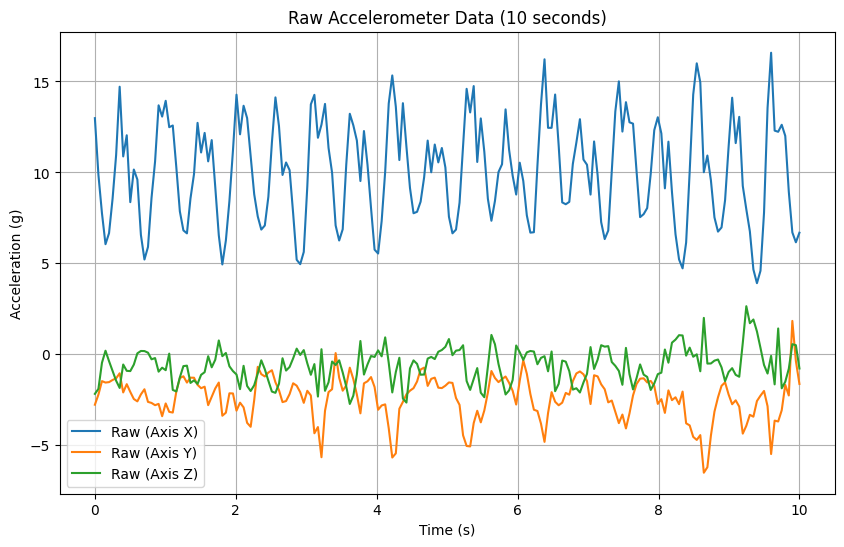

In [12]:
import matplotlib.pyplot as plt

first_10_seconds = acc_raw

# Plot the data for one 10-second instance - before applying filter
time = np.linspace(0, 10, 200)  # Time vector for plotting

# Plot raw and filtered data
plt.figure(figsize=(10, 6))

for i in range(3):
    plt.plot(time, first_10_seconds[:, i], label=f'Raw (Axis {chr(88 + i)})')

plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Raw Accelerometer Data (10 seconds)')
plt.legend()
plt.grid(True)
plt.show()

This is a first-order low-pass filter.

In [13]:
def first_order_lowpass_filter(data, cut_off_freq=0.5, sampling_freq=20):
    """
    Apply a first-order low-pass filter to the input data.

    Args:
    - data (numpy.ndarray): Input data array of shape (num_instances, num_samples_per_instance, num_axes).
    - cut_off_freq (float): Cut-off frequency of the low-pass filter in Hz.
    - sampling_freq (float): Sampling frequency of the input data in Hz.

    Returns:
    - numpy.ndarray: Filtered data array of the same shape as the input data.
    """

    # Calculate filter coefficient
    alpha = np.exp(-2 * np.pi * cut_off_freq / sampling_freq)  # 0.854

    # Initialize filtered data array
    filtered_data_all = np.zeros_like(data)

    # Apply filter to each axis of each instance separately
    for i in range(len(data)):
        for j in range(data.shape[1]):
            if j == 0:
                filtered_data_all[i, j] = data[i, j]
            else:
                filtered_data_all[i, j] = alpha * data[i, j] + (1 - alpha) * filtered_data_all[i, j - 1]

    return filtered_data_all

In [14]:
# Define filter parameters
cut_off_freq = 0.5  # Hz
sampling_freq = 20  # Hz

# Calculate filter coefficient
alpha = np.exp(-2 * np.pi * cut_off_freq / sampling_freq)

# Initialize filtered data array
filtered_data = np.zeros_like(first_10_seconds)

# Apply filter to each axis of each instance
current_index = 0
for i in first_10_seconds:
  if np.array_equal(i, first_10_seconds[0]):
    filtered_data[0] = first_10_seconds[0]
    current_index += 1
  else:
    filtered_data[current_index] = alpha * i + (1 - alpha) * filtered_data[current_index-1]
    current_index += 1

print("Un-Filtered data values")
print(first_10_seconds[20])
print("Filtered data values:")
print(filtered_data[20])

Un-Filtered data values
[13.939192  -2.7044005 -0.8746318]
Filtered data values:
[13.81539396 -2.79221144 -0.85710887]


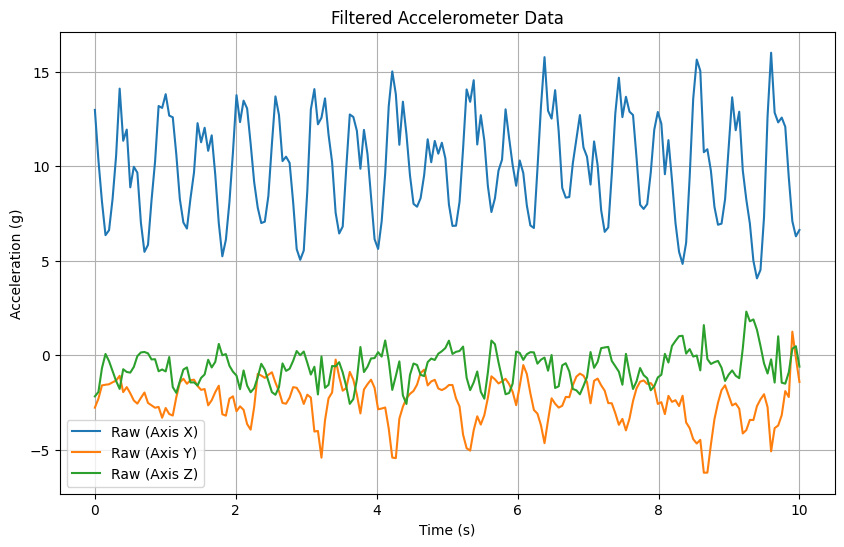

In [15]:
# Plot the data for one 10-second instance - after applying filter
time = np.linspace(0, 10, 200)  # Time vector for plotting

# Plot raw and filtered data
plt.figure(figsize=(10, 6))

for i in range(3):
    plt.plot(time, filtered_data[:, i], label=f'Raw (Axis {chr(88 + i)})')

plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Filtered Accelerometer Data')
plt.legend()
plt.grid(True)
plt.show()

Comparing the mean of values across each axis can be a simple way to check the effectiveness of the filter.

In [16]:
# Combine the values from both acc and gyro into one timestamp
def combine_data(acc_data, gyro_data):
  # Current format {(Timestamp): [[sensorX, sensorY, sensorZ], [sensorX, sensorY, sensorZ] ... 198 ]}
  # Both dictionaries has the same key (Timestamp).

  combined_map = {}
  for key, value in acc_data.items():
    acc_values = acc_data[key]
    gyro_values = gyro_data[key]

    # Put the data through the filter before combining the Acc and Gyro values
    acc_raw = extract_sensor_data(acc_values)
    gyro_raw = extract_sensor_data(gyro_values)

    acc_filtered = first_order_lowpass_filter(acc_raw)
    gyro_filtered = first_order_lowpass_filter(gyro_raw)

    #create an empty array for each timestep. and then add the combined data to that array
    combined_map[key] = []

    for x_index, x_value in enumerate(acc_values):
      #check if there is a corresponding timestamp in the gyro_values for each acc_value
      for y_index, y_value in enumerate(gyro_values):
        x_value[2] = x_value[2]
        # if the timestamps are equal create an array with both the values
        array_all = [acc_filtered[x_index][0], acc_filtered[x_index][1], acc_filtered[x_index][2], gyro_filtered[y_index][0], gyro_filtered[y_index][1], gyro_filtered[y_index][2]]
        combined_map[key].append(array_all)
        break

  return combined_map

set1_combined = combine_data(set1_acc_segmented_data, set1_gyro_segmented_data)
set2_combined = combine_data(set2_acc_segmented_data, set2_gyro_segmented_data)

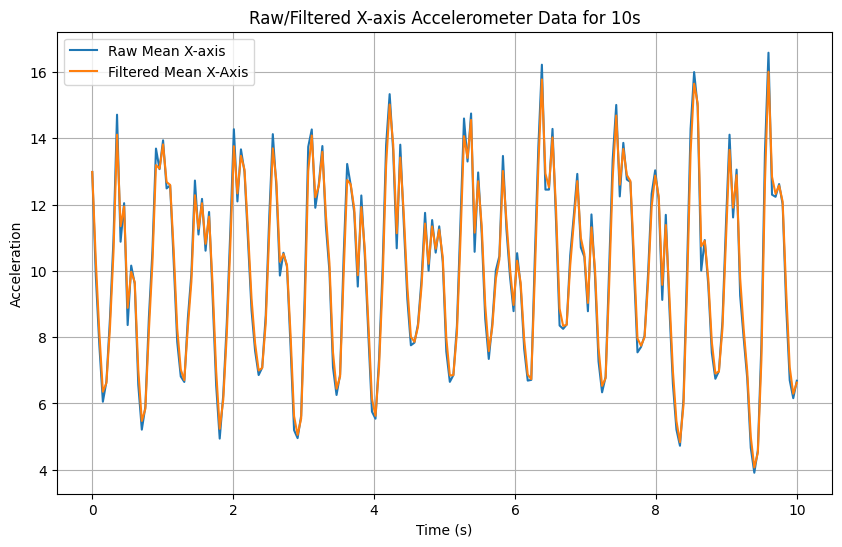

In [17]:
# Compute the mean across each axis and compare
plt.figure(figsize=(10, 6))
plt.plot(time, first_10_seconds[:, 0], label='Raw Mean X-axis')
plt.plot(time, filtered_data[:, 0], label='Filtered Mean X-Axis')

plt.title('Raw/Filtered X-axis Accelerometer Data for 10s')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()

# Creating Pairs of Acc and Gyro Data

In [18]:
# Create pairs and labels
# {timestamp: [[[], [], []]],[]}
# set1_combined, set2_combined
import random
import numpy as np

def create_pairs():
  pairs = []
  labels = []
  random_keys = set()

  # Run a loop for 8 times
  for i in range(0,9):
    #select a random key from the set
    random_pair = []

    while True:
      random_key = random.choice(list(set1_combined.keys()))
      if random_key not in random_keys:
        random_keys.add(random_key)
        random_pair.append(set1_combined[random_key])
        break

    while True:
      random_key = random.choice(list(set2_combined.keys()))
      if random_key not in random_keys:
        random_keys.add(random_key)
        random_pair.append(set2_combined[random_key])
        break

    labels.append(0) #because the two sequences are from two different people
    pairs.append(random_pair)

  set1_keys = set(set1_combined.keys())
  remaining_keys = set1_keys.difference(random_keys)

  for i in range(len(pairs), len(set1_combined)):
    true_pair = []
    for i in remaining_keys:
      if len(true_pair) < 2:
        true_pair.append(set1_combined[i])
      else:
        pairs.append(true_pair)
        labels.append(1)
        break

  print(len(pairs))
  print(labels)
  return pairs, labels

pairs, labels = create_pairs()


17
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


In [19]:
from sklearn.model_selection import train_test_split

# Shuffle pairs and labels, so that the model does not lean any patterns
# Combine pairs and labels
combined_data = list(zip(pairs, labels))

# Shuffle the combined data
random.shuffle(combined_data)

# Unpack the shuffled data back into pairs and labels
shuffled_pairs, shuffled_labels = zip(*combined_data)

train_sequences, val_sequences, train_labels, val_labels = train_test_split(shuffled_pairs, shuffled_labels, test_size=0.2, random_state=42)

print("Number of training data sets: ", len(train_sequences))
print("Each set has an array of length: ", len(train_sequences[0]))
print("One of those two elements in the array contain", len(train_sequences[0][0]), "data points (20hz polling rate, 10 seconds of data).")
print("Each data point has", len(train_sequences[0][0][0]), "elements. 3 accelerometer values and 3 gyroscope values")

train_pairs = np.array(train_sequences)
val_pairs = np.array(val_sequences)

train_labels = np.array(train_labels)
print(train_labels)
val_labels = np.array(val_labels)

print(train_labels.shape)

Number of training data sets:  13
Each set has an array of length:  2
One of those two elements in the array contain 200 data points (20hz polling rate, 10 seconds of data).
Each data point has 6 elements. 3 accelerometer values and 3 gyroscope values
[0 1 0 1 0 1 1 1 1 0 0 1 0]
(13,)


Creating pairs of data for the Simaese network. Ideally the data should look something like this.

Each subject has 17 10-second data instances. The last element in the 2D-Array indicates weather the data is from the same person or not.

1 = Same person
0 = Different people

> [Timestamp] : [[accX, accY, accZ], [gyroX, gyroY, gyroZ], [1]]

> [Timestamp] : [[accX, accY, accZ], [gyroX, gyroY, gyroZ], [0]]






3 Types of Models will be Evaluated for this research.

1.   LSTM (With Bi-Directional Layers),
2.   1D CNN
3.   ConvLSTM

Each Model will be evaluated using 2 Loss functions.

*   Bianry Cross-Entropy
*   Contrastive Loss




# LSTM Model with Binary Cross-Entropy

In [105]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the Siamese model for sequence data
def create_siamese_network(input_shape):
    # Define the base LSTM network (twin network)
    base_network = models.Sequential([
        layers.LSTM(512, input_shape=input_shape, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(256, return_sequences=True),
        layers.LSTM(128),
        layers.Dense(128),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu')
    ])

    # Inputs for two sequences of accelerometer and gyroscope data
    input_a = tf.keras.Input(shape=input_shape)
    input_b = tf.keras.Input(shape=input_shape)

    # Process each sequence through the twin network
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    merged = layers.Concatenate(axis=-1)([processed_a, processed_b])

    # Output layer for similarity prediction
    output = layers.Dense(1, activation='sigmoid')(merged)

    # Siamese model
    siamese_model = tf.keras.Model(inputs=[input_a, input_b], outputs=output)
    return siamese_model

# Define input shape (adjust based on your sequence length and sensor data)
input_shape = (200, 6)  # Replace with your input shape
siamese_network = create_siamese_network(input_shape)

# Compile the model
siamese_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 6)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 200, 6)]             0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64)                   2072256   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 128)                  0         ['sequential[0][0]',      

In [106]:
# Train the model.
history = siamese_network.fit(
    [train_pairs[:, 0], train_pairs[:, 1]],  # Training pairs
    train_labels,  # Training labels
    epochs=10,  # Number of epochs
    batch_size=64,  # Batch size
    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels)  # Validation data
)


Epoch 1/10
1/1 [==============================] - 13s 13s/step - loss: 0.7030 - accuracy: 0.4615 - val_loss: 0.6872 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.6594 - accuracy: 0.5385 - val_loss: 0.6589 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.6980 - accuracy: 0.5385 - val_loss: 0.6553 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.6592 - accuracy: 0.5385 - val_loss: 0.6047 - val_accuracy: 0.7500
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.6675 - accuracy: 0.6154 - val_loss: 0.5244 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.5787 - accuracy: 0.7692 - val_loss: 0.5016 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 0.5484 - accuracy: 0.6923 - val_loss: 0.4430 - val_accuracy: 0.7500
Epoch 8/10
1/1 [=======================

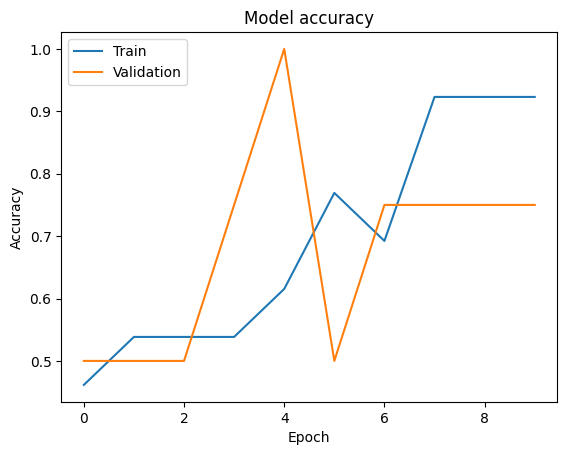

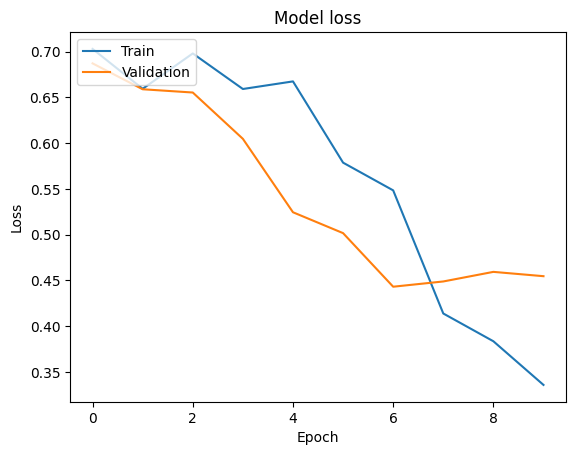

In [107]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# LSTM Model with Contrastive Loss

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

''' A Contrastive Loss funtion provided by Keras (https://keras.io/examples/vision/siamese_contrastive/#define-the-contrastive-loss)'''

def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) + true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - (y_pred), 0))
        return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

In [ ]:
def base_network(input_shape):
    base_network = models.Sequential([
        layers.Bidirectional(layers.LSTM(512, input_shape=input_shape, return_sequences=True)),
        layers.Dropout(0.2),
        layers.LSTM(256, return_sequences=True),
        layers.LSTM(128),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu')
    ])

    input_a = tf.keras.Input(shape=input_shape)
    input_b = tf.keras.Input(shape=input_shape)

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Calculating the cosine similarity between the embeddings
    cosine_sim = tf.keras.layers.Dot(axes=1, normalize=True)([processed_a, processed_b])
    output = layers.Dense(1, activation='sigmoid')(cosine_sim)

    model = tf.keras.Model(inputs=[input_a, input_b], outputs=output)
    return model

# Example usage
input_shape = (200, 6)  # Specify input shape
LSTM_Contrastive_SNN = base_network(input_shape)

# Compile the model with contrastive loss
LSTM_Contrastive_SNN.compile(optimizer='adam', loss=loss(margin=1), metrics=['accuracy'])

In [ ]:
train_labels = tf.cast(train_labels, tf.float32)
val_labels = tf.cast(val_labels, tf.float32)

In [ ]:
# Train the model.
history = LSTM_Contrastive_SNN.fit(
    [train_pairs[:, 0], train_pairs[:, 1]],  # Training pairs
    train_labels,  # Training labels
    epochs = 50,  # Number of epochs
    batch_size = 32,  # Batch size
    validation_data = ([val_pairs[:, 0], val_pairs[:, 1]], val_labels),  # Validation data
    callbacks = [tf.keras.callbacks.LambdaCallback(on_batch_begin=lambda batch,logs: tf.print("Batch", batch))] # Print some logs per batch
)

Epoch 1/10
Batch 0
1/1 [==============================] - 30s 30s/step - loss: 0.2653 - accuracy: 0.5385 - val_loss: 0.2805 - val_accuracy: 0.5000
Epoch 2/10
Batch 0
1/1 [==============================] - 10s 10s/step - loss: 0.2635 - accuracy: 0.5385 - val_loss: 0.2798 - val_accuracy: 0.5000
Epoch 3/10
Batch 0
1/1 [==============================] - 10s 10s/step - loss: 0.2516 - accuracy: 0.5385 - val_loss: 0.2792 - val_accuracy: 0.5000
Epoch 4/10
Batch 0
1/1 [==============================] - 10s 10s/step - loss: 0.2519 - accuracy: 0.5385 - val_loss: 0.2782 - val_accuracy: 0.5000
Epoch 5/10
Batch 0
1/1 [==============================] - 10s 10s/step - loss: 0.2532 - accuracy: 0.5385 - val_loss: 0.2729 - val_accuracy: 0.5000
Epoch 6/10
Batch 0
1/1 [==============================] - 11s 11s/step - loss: 0.2468 - accuracy: 0.5385 - val_loss: 0.2648 - val_accuracy: 0.5000
Epoch 7/10
Batch 0
1/1 [==============================] - 9s 9s/step - loss: 0.2475 - accuracy: 0.5385 - val_loss: 0.2

# 1D CNN with Binary Cross-Entropy

In [23]:
# Create the CNN model
def create_cnn_siamese_network(input_shape):
    # Define the base LSTM network (twin network)
    base_network = models.Sequential([
        layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        #layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5)
    ])

    # Inputs for two sequences of accelerometer and gyroscope data
    input_a = tf.keras.Input(shape=input_shape)
    input_b = tf.keras.Input(shape=input_shape)

    # Process each sequence through the twin network
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Calculating the cosine similarity between the embeddings
    cosine_sim = tf.keras.layers.Dot(axes=1, normalize=True)([processed_a, processed_b])

    # Output layer for similarity prediction
    output = layers.Dense(1, activation='sigmoid')(cosine_sim)

    # Siamese model
    siamese_model = tf.keras.Model(inputs=[input_a, input_b], outputs=output)
    return siamese_model

# Define input shape (adjust based on your sequence length and sensor data)
input_shape = (200, 6)  # Replace with your input shape
cnn_siamese_network = create_cnn_siamese_network(input_shape)

# Compile the model
cnn_siamese_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
cnn_siamese_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 200, 6)]             0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 200, 6)]             0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 256)                  785440    ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 dot (Dot)                   (None, 1)                    0         ['sequential_1[0][0]',  

In [24]:
# Train the cnn model.
cnn_history = cnn_siamese_network.fit(
    [train_pairs[:, 0], train_pairs[:, 1]],  # Training pairs
    train_labels,  # Training labels
    epochs=30,  # Number of epochs
    batch_size=32,  # Batch size
    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels)  # Validation data
)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 0.7576 - accuracy: 0.4615 - val_loss: 0.5632 - val_accuracy: 0.7500
Epoch 2/30
1/1 [==============================] - 0s 111ms/step - loss: 0.7355 - accuracy: 0.4615 - val_loss: 0.5625 - val_accuracy: 0.7500
Epoch 3/30
1/1 [==============================] - 0s 164ms/step - loss: 0.7388 - accuracy: 0.4615 - val_loss: 0.5623 - val_accuracy: 0.7500
Epoch 4/30
1/1 [==============================] - 0s 135ms/step - loss: 0.7546 - accuracy: 0.4615 - val_loss: 0.5621 - val_accuracy: 0.7500
Epoch 5/30
1/1 [==============================] - 0s 131ms/step - loss: 0.7727 - accuracy: 0.4615 - val_loss: 0.5621 - val_accuracy: 0.7500
Epoch 6/30
1/1 [==============================] - 0s 105ms/step - loss: 0.7287 - accuracy: 0.4615 - val_loss: 0.5620 - val_accuracy: 0.7500
Epoch 7/30
1/1 [==============================] - 0s 105ms/step - loss: 0.7881 - accuracy: 0.4615 - val_loss: 0.5619 - val_accuracy: 0.7500
Epoch 8/30
1/1 [=======

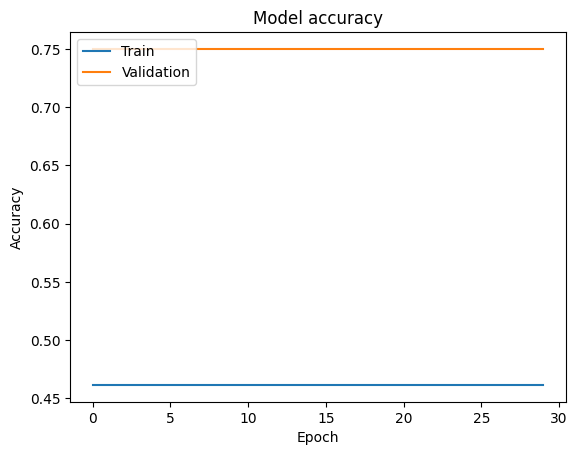

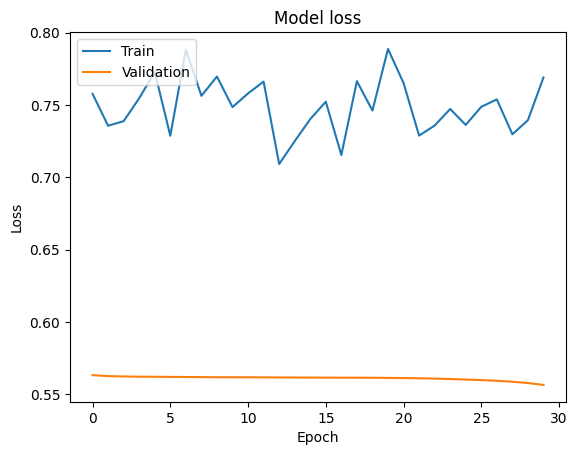

In [25]:
# Plot training & validation accuracy values
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 1D CNN with Contrastive loss

In [ ]:
# Create the CNN model
def contrastive_loss(y_true, y_pred, margin=1):
    # y_true: true labels (0 for dissimilar pairs, 1 for similar pairs)
    # y_pred: predicted similarity scores (cosine similarity)

    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32

    square_pred = tf.square(1 - y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))

    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

def cnn_contrastive(input_shape):
    # Define the base LSTM network (twin network)
    base_network = models.Sequential([
        layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        #layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5)
    ])

    # Inputs for two sequences of accelerometer and gyroscope data
    input_a = tf.keras.Input(shape=input_shape)
    input_b = tf.keras.Input(shape=input_shape)

    # Process each sequence through the twin network
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Compute cosine similarity
    cosine_sim = tf.keras.layers.Dot(axes=1, normalize=True)([processed_a, processed_b])

    # Siamese model
    siamese_model = tf.keras.Model(inputs=[input_a, input_b], outputs=cosine_sim)
    return siamese_model

# Define input shape (adjust based on your sequence length and sensor data)
input_shape = (200, 6)  # Replace with your input shape
cnn_snn = cnn_contrastive(input_shape)

# Compile the model
cnn_snn.compile(optimizer='adam', loss=contrastive_loss)

# Print model summary
cnn_snn.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 200, 6)]             0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 200, 6)]             0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 256)                  785440    ['input_7[0][0]',             
                                                                     'input_8[0][0]']             
                                                                                                  
 dot_2 (Dot)                 (None, 1)                    0         ['sequential_3[0][0]',  

In [ ]:
# Train the cnn model.
cnn_history = cnn_snn.fit(
    [train_pairs[:, 0], train_pairs[:, 1]],  # Training pairs
    train_labels,  # Training labels
    epochs=30,  # Number of epochs
    batch_size=32,  # Batch size
    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels)  # Validation data
)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.3427 - val_loss: 9.9131e-04
Epoch 2/30
1/1 [==============================] - 0s 74ms/step - loss: 0.2647 - val_loss: 1.8794e-04
Epoch 3/30
1/1 [==============================] - 0s 81ms/step - loss: 0.3315 - val_loss: 7.8324e-05
Epoch 4/30
1/1 [==============================] - 0s 275ms/step - loss: 0.2905 - val_loss: 3.7706e-05
Epoch 5/30
1/1 [==============================] - 0s 259ms/step - loss: 0.2353 - val_loss: 2.1629e-05
Epoch 6/30
1/1 [==============================] - 0s 155ms/step - loss: 0.3136 - val_loss: 1.2957e-05
Epoch 7/30
1/1 [==============================] - 0s 163ms/step - loss: 0.2877 - val_loss: 8.3475e-06
Epoch 8/30
1/1 [==============================] - 0s 77ms/step - loss: 0.2371 - val_loss: 5.9818e-06
Epoch 9/30
1/1 [==============================] - 0s 75ms/step - loss: 0.2970 - val_loss: 4.5171e-06
Epoch 10/30
1/1 [==============================] - 0s 69ms/step - loss: 0.2499 - val_loss

# Save and Export Model

In [ ]:
# Save the entire model to a HDF5 file (including architecture, weights, and training configuration)
siamese_network.save('siamese_model.tflite')

In [ ]:
# Compress the folder
#!zip -r /content/folder_name.zip /content/siamese_model.tflite

# Generate a download link
#from google.colab import files
#files.download("/content/folder_name.zip")

  adding: content/siamese_model.tflite/ (stored 0%)
  adding: content/siamese_model.tflite/variables/ (stored 0%)
  adding: content/siamese_model.tflite/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/siamese_model.tflite/variables/variables.index (deflated 65%)
  adding: content/siamese_model.tflite/saved_model.pb (deflated 90%)
  adding: content/siamese_model.tflite/assets/ (stored 0%)
  adding: content/siamese_model.tflite/fingerprint.pb (stored 0%)
  adding: content/siamese_model.tflite/keras_metadata.pb (deflated 93%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>